In [1]:
from util import *


from src.dataset import load_mnist
from src.counterfactual import get_baseline_counterfactuals
import joblib

import warnings
warnings.filterwarnings('ignore')
                        
# Get a model
dataset = 'mnist'
model = joblib.load('models/mnist.gz') # Model should have the BlackBox interface
model

2023-01-30 23:12:01.671340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


MnistModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=10, bias=True)
)

In [2]:
loader = get_loader(dataset)
X_corpus, _ = next(loader)
X_test, _ = next(loader)

simplex = get_simplex(model, X_corpus, X_test, verbose = True)

Weight Fitting Epoch: 2000/10000 ; Error: 3.45e+04 ; Regulator: 449 ; Reg Factor: 1
Weight Fitting Epoch: 4000/10000 ; Error: 1.45e+04 ; Regulator: 283 ; Reg Factor: 1
Weight Fitting Epoch: 6000/10000 ; Error: 1.03e+04 ; Regulator: 135 ; Reg Factor: 1
Weight Fitting Epoch: 8000/10000 ; Error: 9.51e+03 ; Regulator: 81 ; Reg Factor: 1
Weight Fitting Epoch: 10000/10000 ; Error: 9.25e+03 ; Regulator: 61.2 ; Reg Factor: 1


In [3]:
%%time
test_id = 1

cfs, x, desired_class = get_simplex_cf_image(simplex, model, test_id, n_cfs = 1)

CPU times: user 2.79 s, sys: 526 ms, total: 3.32 s
Wall time: 482 ms


<Figure size 200x600 with 0 Axes>

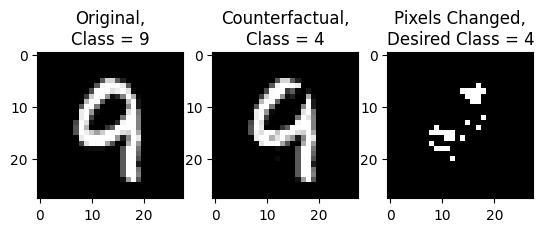

In [4]:
display_image_cfs(cfs, model, x, desired_class, 'results/mnist_simplex_sample')

<Figure size 200x600 with 0 Axes>

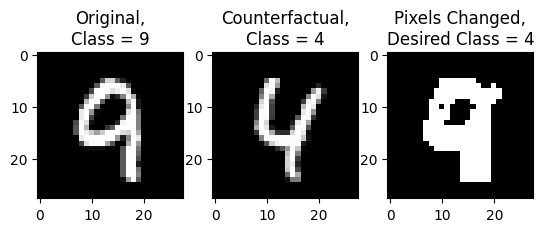

In [5]:
baseline_cfs = get_baseline_counterfactuals(model = model, target = desired_class, test = x, \
                                            corpus = X_corpus)
display_image_cfs(baseline_cfs, model, x, desired_class, 'results/mnist_nn_sample')

2023-01-30 23:13:37.478614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 23:13:37.630726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


<Figure size 200x600 with 0 Axes>

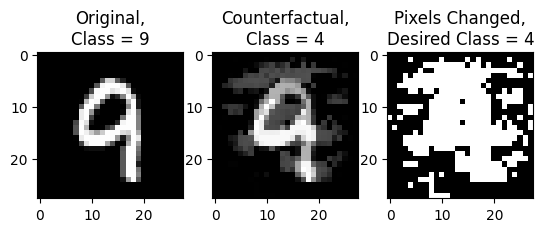

CPU times: user 8min 48s, sys: 46.1 s, total: 9min 34s
Wall time: 1min 16s


In [6]:
%%time
cf_proto_cf = get_cf_nproto_cf(X_corpus, model, x)
display_image_cfs(cf_proto_cf, model, x, desired_class, 'results/mnist_cfproto_sample')

# Comparison

In [7]:
from tqdm import tqdm 
import time

times = []
sparsity = []
success_rate = []
in_distribution = []

from sklearn.svm import OneClassSVM
ood_detector = OneClassSVM()
ood_detector.fit(X_test.reshape(len(X_test), -1))

for test_id in tqdm(range(50)):
    start = time.time()
    cfs, x, desired_class = get_simplex_cf_image(simplex, model, test_id, n_cfs = 1)
    if cfs is None:
        cfs = torch.ones_like(x)
    end = time.time()
    
    start_b = time.time()
    baseline_cfs = get_baseline_counterfactuals(model = model, target = desired_class, test = x, \
                                            corpus = X_corpus)
    end_b = time.time()
    
    start_c = time.time()
    cf_proto_cf = get_cf_nproto_cf(X_corpus, model, x)
    end_c = time.time()
    
    times.append([end - start, end_b - start_b, end_c - start_c])
    sparsity.append([(cfs[0] != x).sum(), (baseline_cfs[0] != x).sum(), (cf_proto_cf[0] != x).sum()])
    success_rate.append([cfs is not None, baseline_cfs is not None, cf_proto_cf is not None])
    in_distribution.append([ood_detector.score_samples(cfs.reshape(1, -1)).mean(), \
        ood_detector.score_samples(baseline_cfs.reshape(1, -1)).mean(), ood_detector.score_samples(cf_proto_cf.reshape(1, -1)).mean()])

100%|██████████| 50/50 [54:06<00:00, 64.92s/it] 


In [8]:
pd.DataFrame(times, columns  = ['simplex', 'nn', 'cfproto']).describe().to_csv(f'results/{dataset}_times.csv')
pd.DataFrame(sparsity, columns  = ['simplex', 'nn', 'cfproto']).applymap(int).describe().to_csv(f'results/{dataset}_sparsity.csv')
pd.DataFrame(success_rate, columns  = ['simplex', 'nn', 'cfproto']).applymap(int).describe().to_csv(f'results/{dataset}_success_rate.csv')
pd.DataFrame(in_distribution, columns  = ['simplex', 'nn', 'cfproto']).describe().to_csv(f'results/{dataset}_in_distribution.csv')

In [10]:
ood_detector.score_samples(X_test.reshape(len(X_test), -1)).mean()

56.24620231532454